<a href="https://colab.research.google.com/github/shayaan-1/credit-card-behavior-analysis/blob/main/Creditcards_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Import Required Libraries and Setup**

In [ ]:
# === IMPORTS AND SETUP ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# Plot settings
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


**2.Load and Initial Data Exploration**

In [ ]:
# === LOAD DATA ===
df = pd.read_csv('/content/credit_card_transactions.csv')

print("=== INITIAL DATA OVERVIEW ===")
print("Shape:", df.shape)
print("\n=== First 5 rows ===")
print(df.head())

print("\n=== Dataset Info ===")
print(df.info())

print("\n=== Summary Statistics ===")
print(df.describe(include='all').T)

=== INITIAL DATA OVERVIEW ===
Shape: (388388, 24)

=== First 5 rows ===
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street            city state  \
0    Banks      F                561 Perry Cove  Moravian Fal

**3.Data Quality Assessment**

=== MISSING VALUES ===
state                1
zip                  1
lat                  1
long                 1
city_pop             1
job                  1
dob                  1
trans_num            1
unix_time            1
merch_lat            1
merch_long           1
is_fraud             1
merch_zipcode    58732
dtype: int64


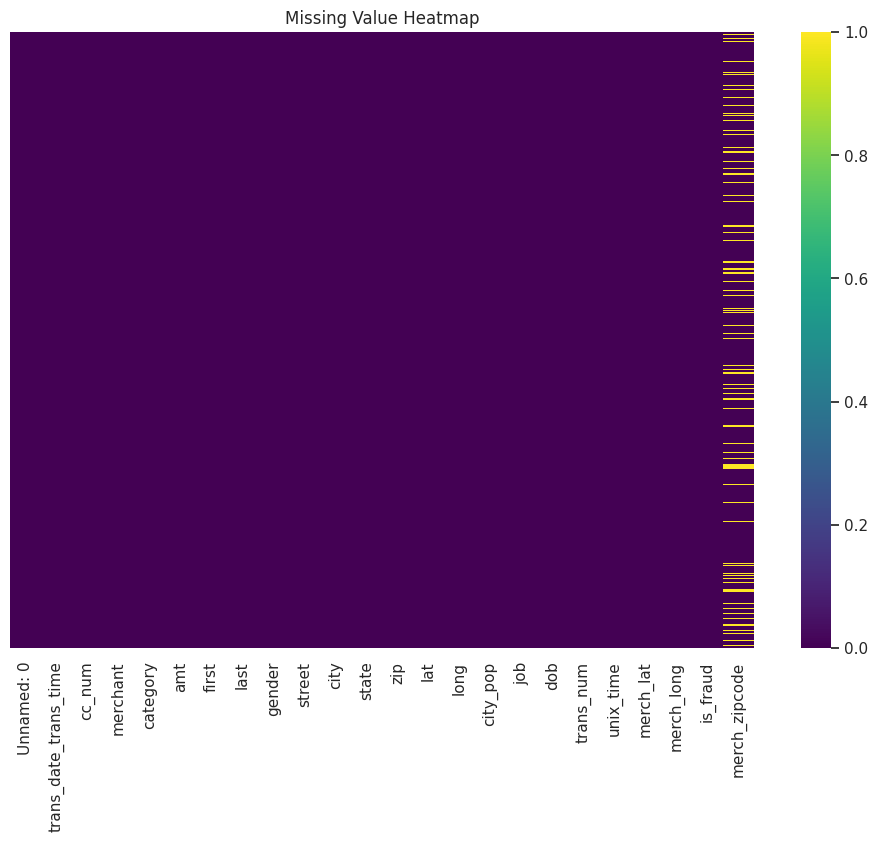


=== DUPLICATE ROWS ===
Duplicates: 0

=== DATA TYPES ===
Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                      float64
lat                      float64
long                     float64
city_pop                 float64
job                       object
dob                       object
trans_num                 object
unix_time                float64
merch_lat                float64
merch_long               float64
is_fraud                 float64
merch_zipcode            float64
dtype: object


In [ ]:
# === DATA QUALITY CHECKS ===

# Missing Values
print("=== MISSING VALUES ===")
missing = df.isnull().sum()
print(missing[missing > 0])

# Missing values heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title("Missing Value Heatmap")
plt.show()

# Duplicate Rows
print("\n=== DUPLICATE ROWS ===")
print("Duplicates:", df.duplicated().sum())

# Data types
print("\n=== DATA TYPES ===")
print(df.dtypes)

**4.Data Preprocessing and Feature Engineering**

In [ ]:
# === DATA PREPROCESSING ===

# Create a copy for processing
df_processed = df.copy()

# Convert datetime columns
df_processed['trans_date_trans_time'] = pd.to_datetime(df_processed['trans_date_trans_time'], errors='coerce')
df_processed['dob'] = pd.to_datetime(df_processed['dob'], errors='coerce')

# Extract time features
df_processed['hour'] = df_processed['trans_date_trans_time'].dt.hour
df_processed['day_of_week'] = df_processed['trans_date_trans_time'].dt.dayofweek
df_processed['month'] = df_processed['trans_date_trans_time'].dt.month
df_processed['is_weekend'] = df_processed['day_of_week'].isin([5, 6]).astype(int)

# Calculate age
df_processed['age'] = (df_processed['trans_date_trans_time'] - df_processed['dob']).dt.days / 365.25

# Calculate distance between customer and merchant
df_processed['distance'] = np.sqrt((df_processed['lat'] - df_processed['merch_lat'])**2 +
                                  (df_processed['long'] - df_processed['merch_long'])**2) * 111  # Convert to km

# Time-based features
df_processed['time_period'] = pd.cut(df_processed['hour'],
                                    bins=[0, 6, 12, 18, 24],
                                    labels=['Night', 'Morning', 'Afternoon', 'Evening'])

print("✅ Feature engineering completed!")
print("New features added:", ['hour', 'day_of_week', 'month', 'is_weekend', 'age', 'distance', 'time_period'])
print("Processed data shape:", df_processed.shape)

✅ Feature engineering completed!
New features added: ['hour', 'day_of_week', 'month', 'is_weekend', 'age', 'distance', 'time_period']
Processed data shape: (388388, 31)


**5.Univariate Analysis - Numerical Variables**

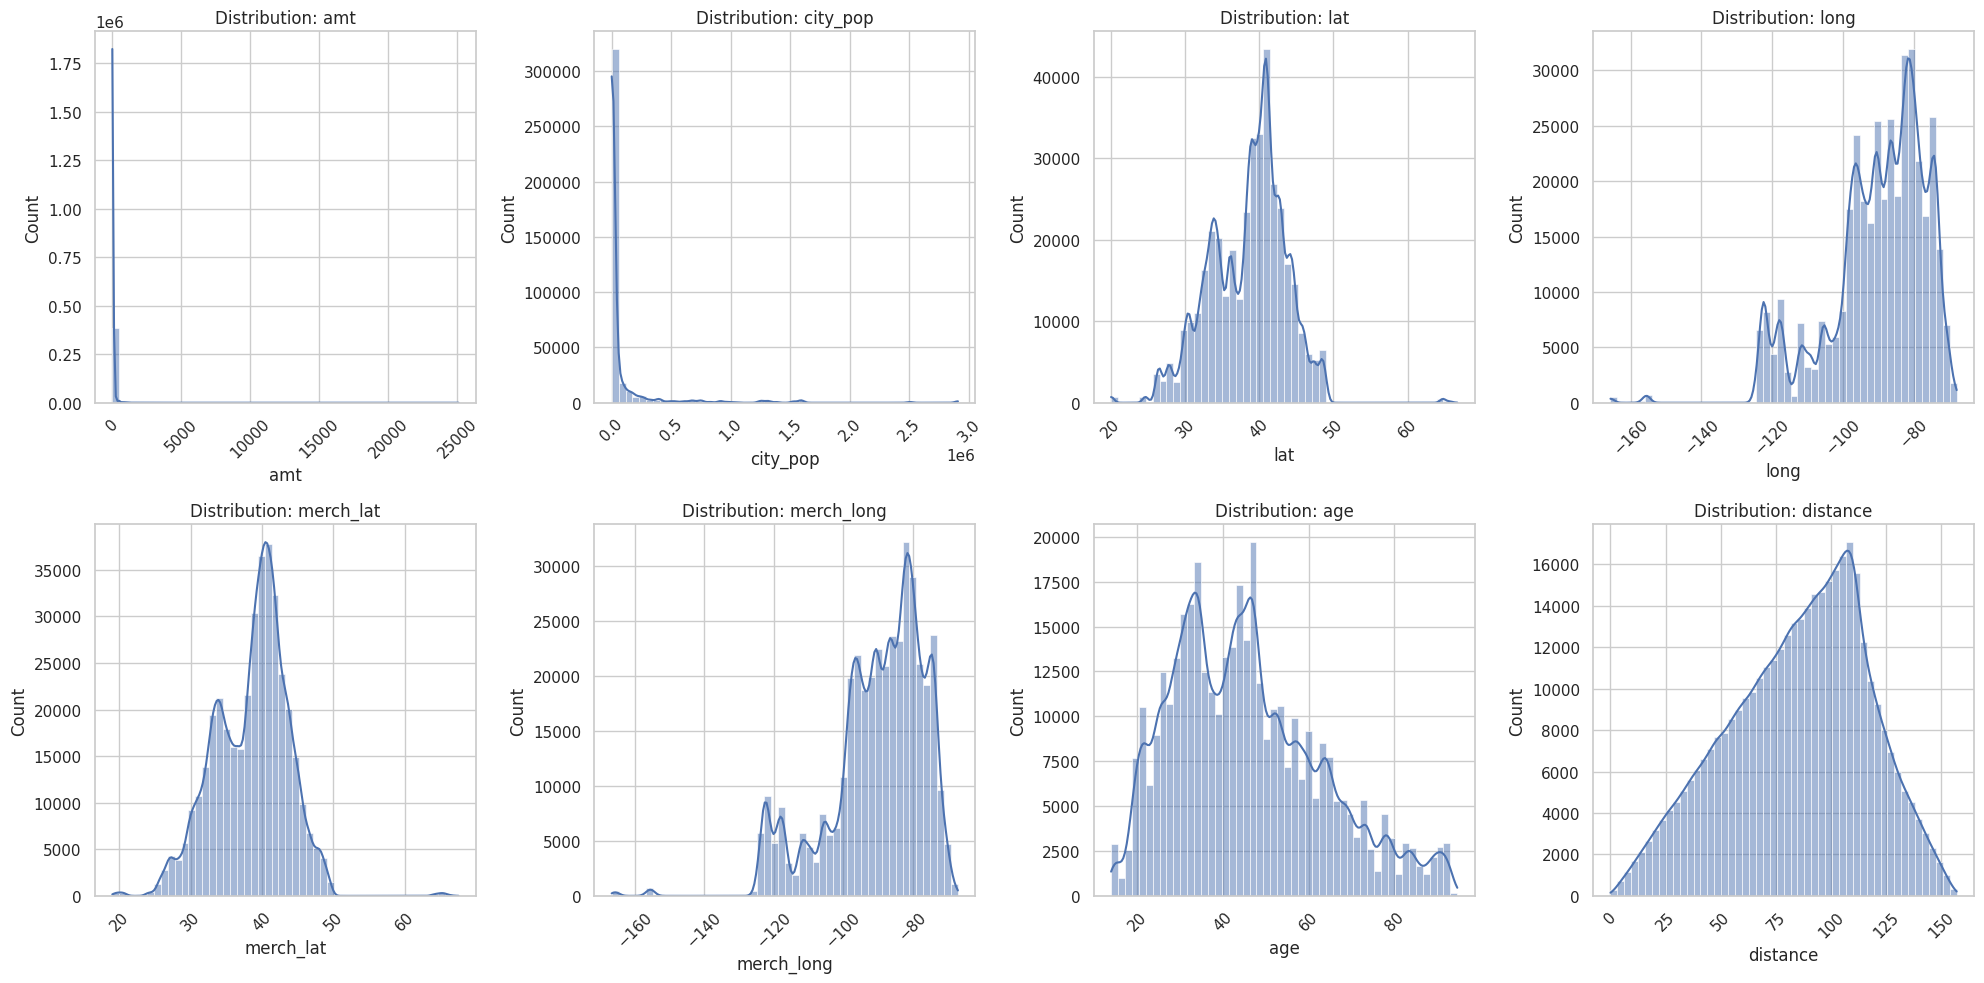

=== NUMERICAL VARIABLES SUMMARY ===
                 amt      city_pop            lat           long  \
count  388388.000000  3.883870e+05  388387.000000  388387.000000   
mean       70.638859  8.958233e+04      38.537615     -90.221031   
std       159.820618  3.038591e+05       5.076004      13.775796   
min         1.000000  2.300000e+01      20.027100    -165.672300   
25%         9.660000  7.430000e+02      34.668900     -96.798000   
50%        47.600000  2.456000e+03      39.354300     -87.461600   
75%        83.290000  2.047800e+04      41.940400     -80.138100   
max     25086.940000  2.906700e+06      66.693300     -67.950300   

           merch_lat     merch_long            age       distance  
count  388387.000000  388387.000000  388387.000000  388387.000000  
mean       38.537222     -90.220905      45.554177      85.046009  
std         5.110087      13.788295      17.365764      31.579380  
min        19.029798    -166.671242      13.921971       0.026492  
25%        

In [ ]:
# === UNIVARIATE ANALYSIS - NUMERICAL ===

num_cols = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'age', 'distance']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    if col in df_processed.columns:
        sns.histplot(df_processed[col].dropna(), bins=50, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution: {col}')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Basic statistics for numerical columns
print("=== NUMERICAL VARIABLES SUMMARY ===")
print(df_processed[num_cols].describe())

**6. Univariate Analysis - Categorical Variables**

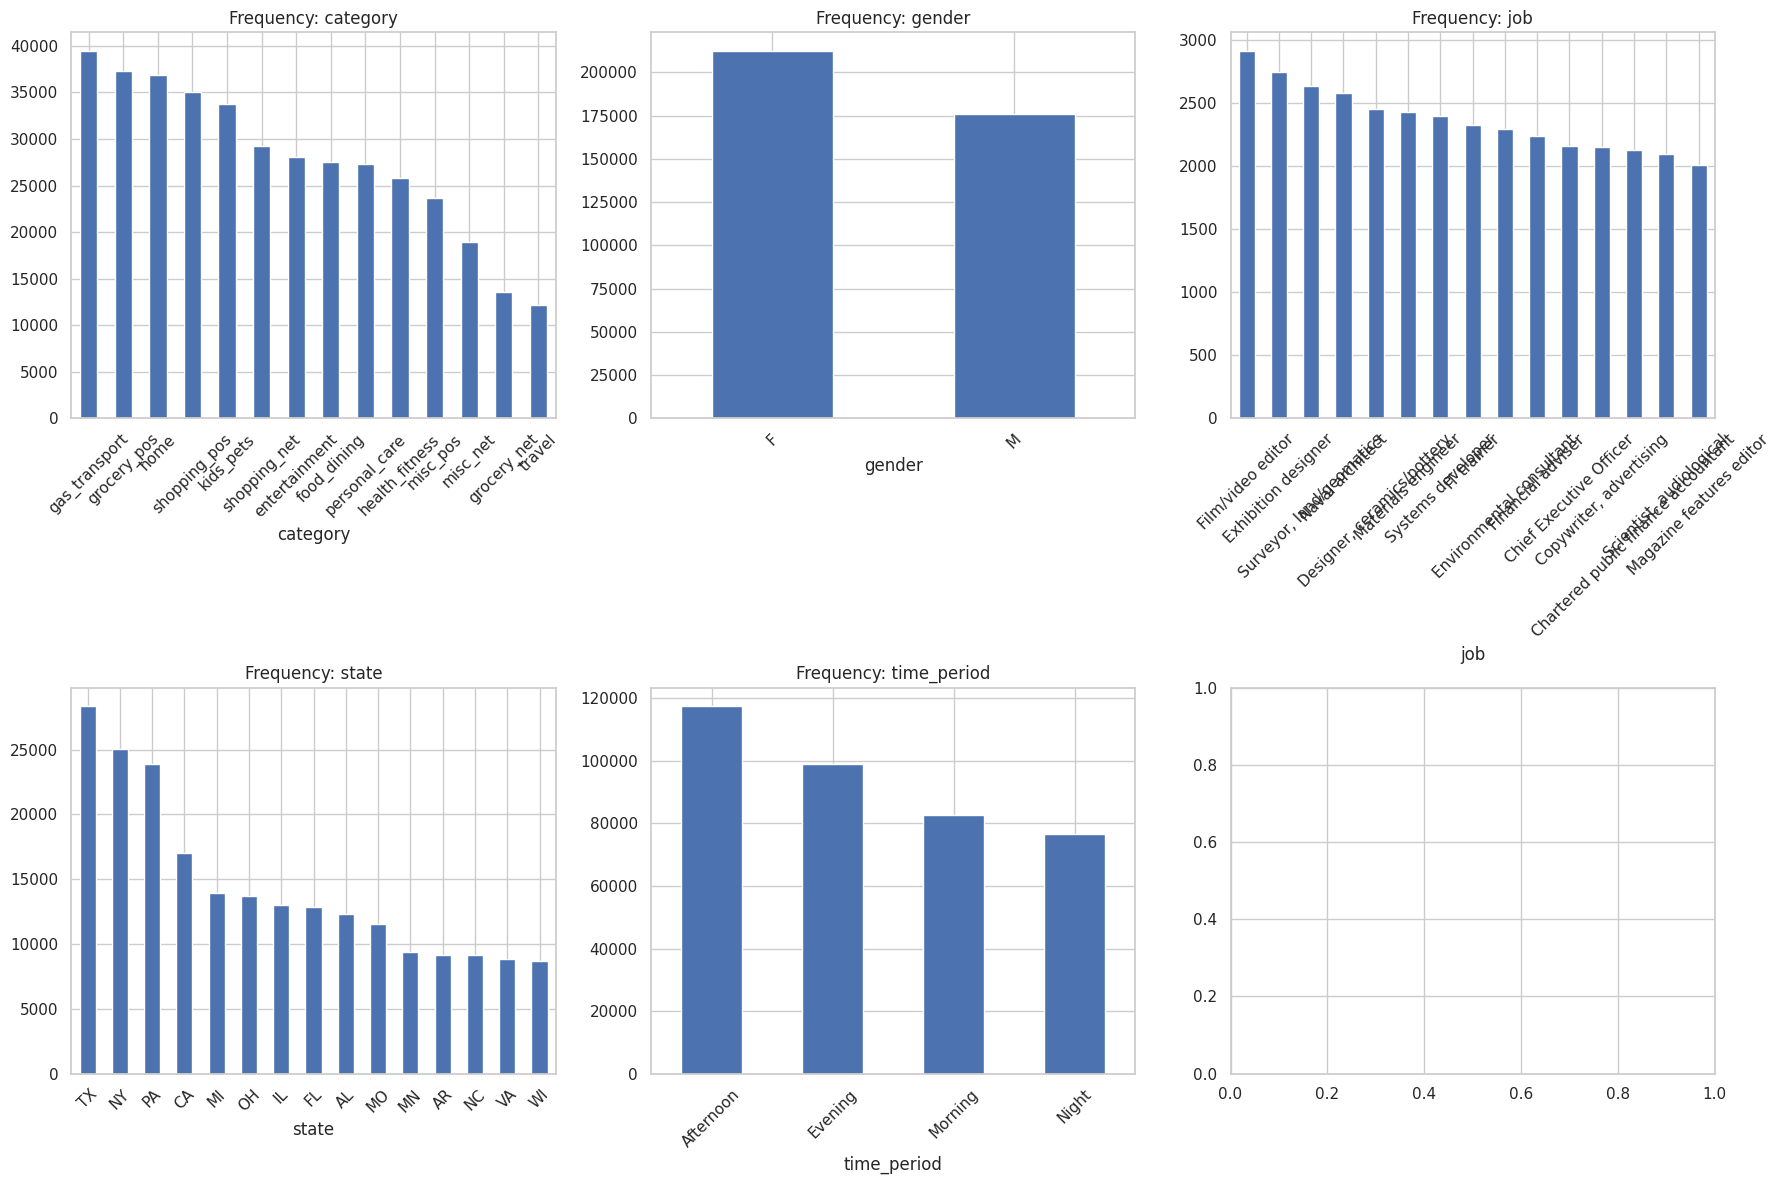


=== CATEGORY DISTRIBUTION ===
category
gas_transport     39469
grocery_pos       37247
home              36814
shopping_pos      35061
kids_pets         33731
shopping_net      29222
entertainment     28051
food_dining       27517
personal_care     27261
health_fitness    25832
Name: count, dtype: int64

=== GENDER DISTRIBUTION ===
gender
F    212489
M    175899
Name: count, dtype: int64

=== JOB DISTRIBUTION ===
job
Film/video editor             2917
Exhibition designer           2751
Surveyor, land/geomatics      2637
Naval architect               2583
Designer, ceramics/pottery    2451
Materials engineer            2428
Systems developer             2403
IT trainer                    2329
Environmental consultant      2293
Financial adviser             2242
Name: count, dtype: int64

=== STATE DISTRIBUTION ===
state
TX    28379
NY    25042
PA    23866
CA    17009
MI    13941
OH    13696
IL    12981
FL    12864
AL    12338
MO    11579
Name: count, dtype: int64

=== TIME_PERIOD DISTR

In [ ]:
# === UNIVARIATE ANALYSIS - CATEGORICAL ===

cat_cols = ['category', 'gender', 'job', 'state', 'time_period']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(cat_cols):
    if col in df_processed.columns and i < len(axes):
        top_categories = df_processed[col].value_counts().head(15)
        top_categories.plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Frequency: {col}')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print categorical summaries
for col in cat_cols:
    if col in df_processed.columns:
        print(f"\n=== {col.upper()} DISTRIBUTION ===")
        print(df_processed[col].value_counts().head(10))

**7.Bivariate Analysis and Correlations**

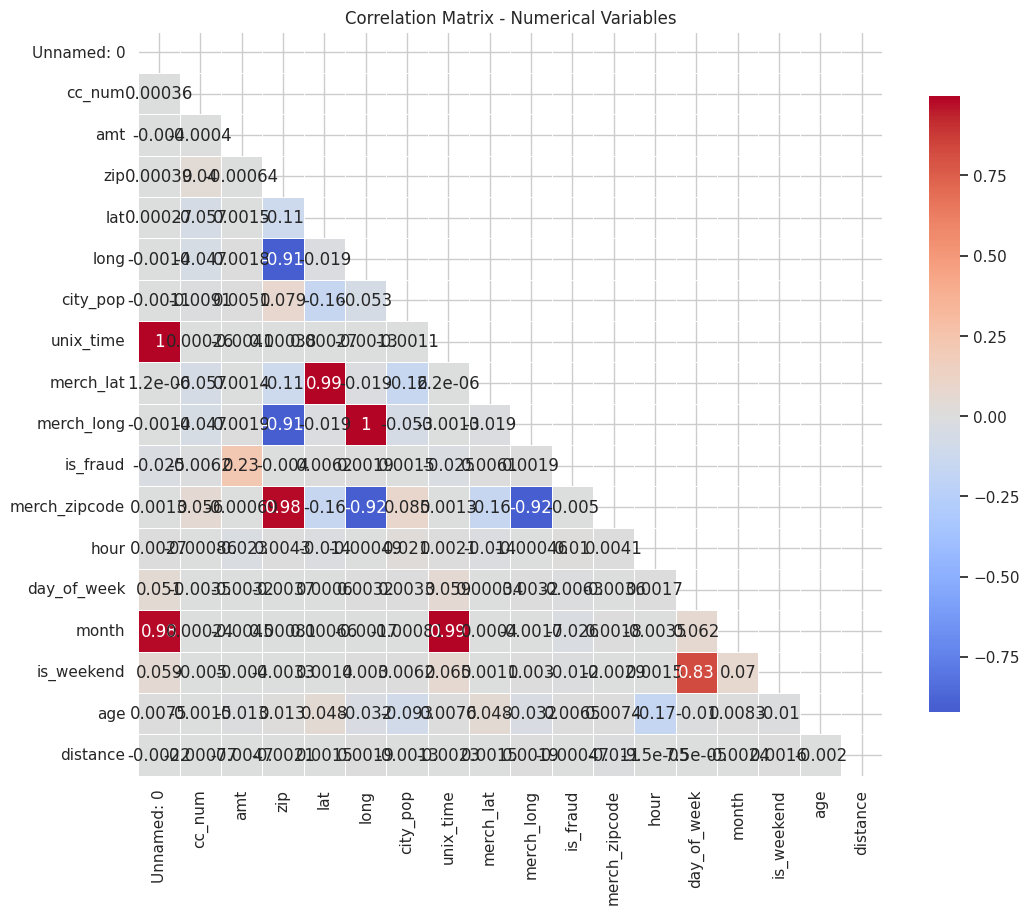

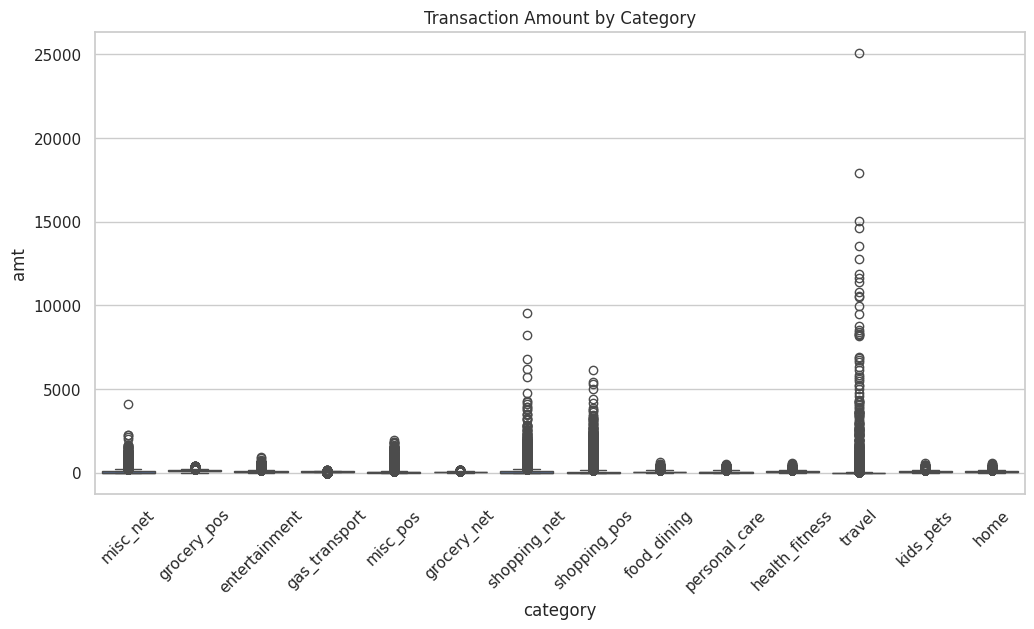

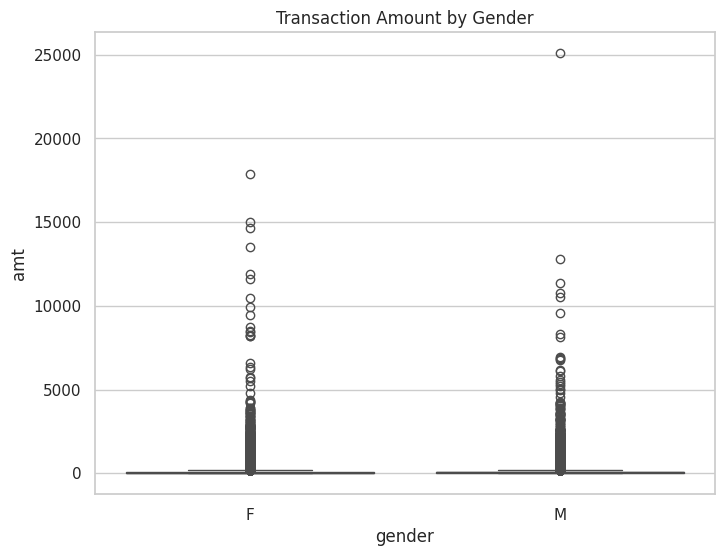

In [ ]:
# === BIVARIATE ANALYSIS ===

# Correlation matrix for numerical variables
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df_processed[numeric_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix - Numerical Variables")
plt.show()

# Amount vs Category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_processed, x='category', y='amt')
plt.title('Transaction Amount by Category')
plt.xticks(rotation=45)
plt.show()

# Amount vs Gender
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_processed, x='gender', y='amt')
plt.title('Transaction Amount by Gender')
plt.show()

**8.Outlier Detection and Analysis**

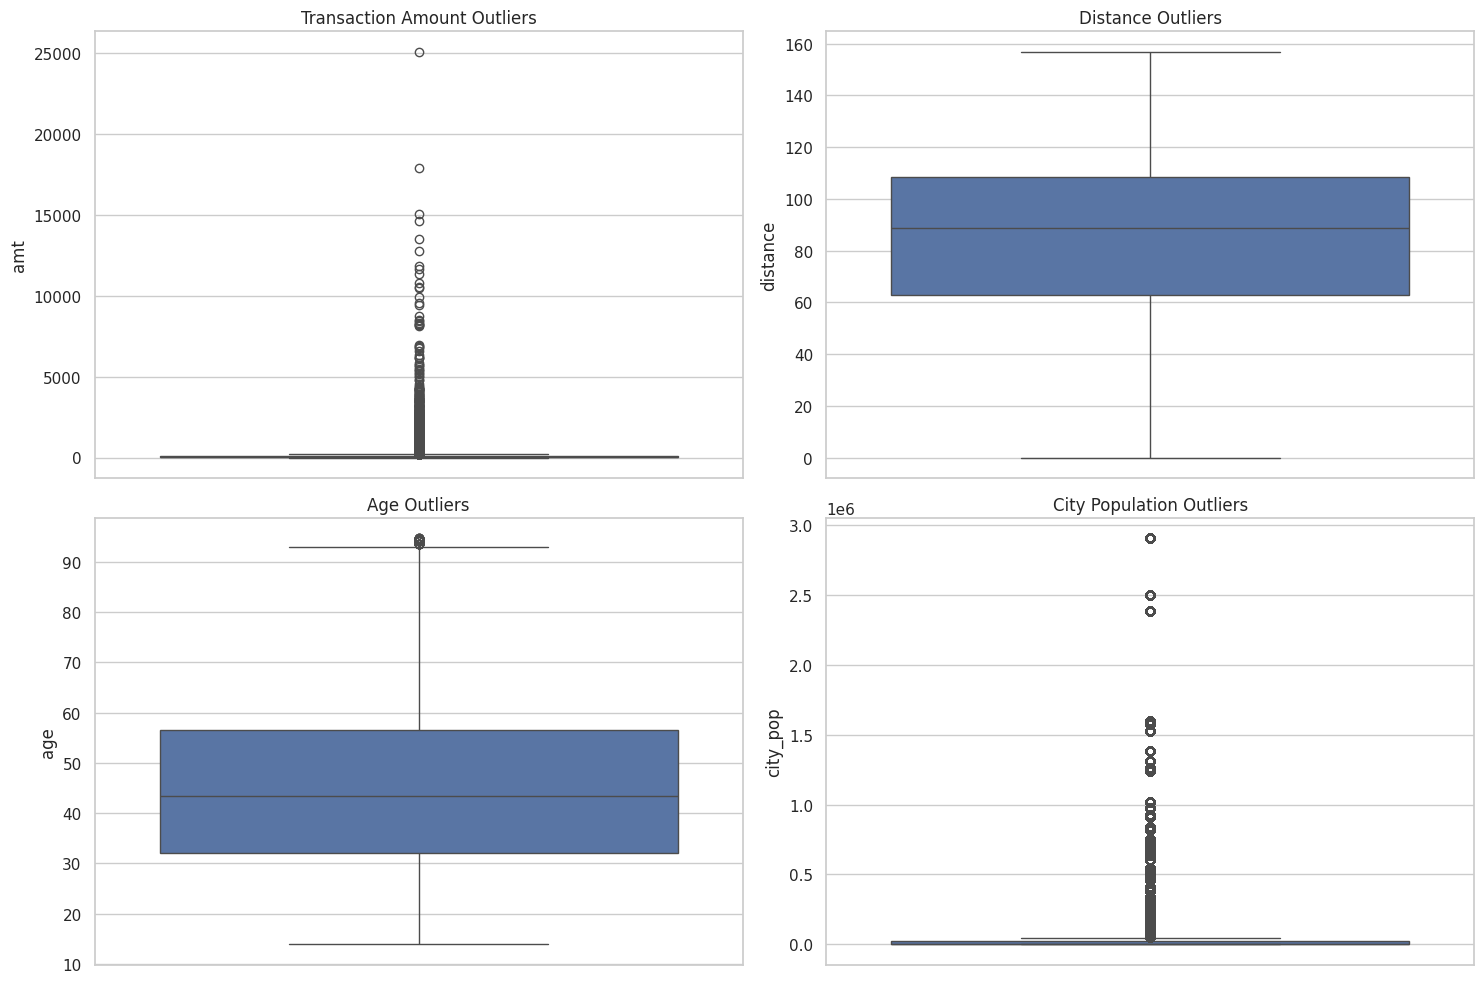

=== TRANSACTION AMOUNT PERCENTILES ===
50th percentile: $47.60
75th percentile: $83.29
90th percentile: $137.03
95th percentile: $196.89
99th percentile: $550.99
99.9th percentile: $1501.99


In [ ]:
# === OUTLIER ANALYSIS ===

# Box plots for key numerical variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Transaction amounts
sns.boxplot(data=df_processed, y='amt', ax=axes[0,0])
axes[0,0].set_title('Transaction Amount Outliers')

# Distance
sns.boxplot(data=df_processed, y='distance', ax=axes[0,1])
axes[0,1].set_title('Distance Outliers')

# Age
sns.boxplot(data=df_processed, y='age', ax=axes[1,0])
axes[1,0].set_title('Age Outliers')

# City population
sns.boxplot(data=df_processed, y='city_pop', ax=axes[1,1])
axes[1,1].set_title('City Population Outliers')

plt.tight_layout()
plt.show()

# Quantile analysis for amount
print("=== TRANSACTION AMOUNT PERCENTILES ===")
percentiles = [50, 75, 90, 95, 99, 99.9]
for p in percentiles:
    value = np.percentile(df_processed['amt'].dropna(), p)
    print(f"{p}th percentile: ${value:.2f}")

**9. Data Cleaning and Imputation**

In [ ]:
# === DATA CLEANING ===

print("=== DATA CLEANING PROCESS ===")
print(f"Original shape: {df_processed.shape}")

# Handle missing values
missing_before = df_processed.isnull().sum().sum()
print(f"Missing values before cleaning: {missing_before}")

# Fill numeric NaNs with median
numeric_columns = ['city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'age', 'distance']

for col in numeric_columns:
    if col in df_processed.columns:
        median_val = df_processed[col].median()
        df_processed[col] = df_processed[col].fillna(median_val)
        print(f"Filled {col} missing values with median: {median_val:.2f}")

# Drop rows with any remaining critical NaNs
df_cleaned = df_processed.dropna(subset=['trans_date_trans_time', 'cc_num', 'amt'])

missing_after = df_cleaned.isnull().sum().sum()
print(f"Missing values after cleaning: {missing_after}")
print(f"Final cleaned shape: {df_cleaned.shape}")

# Save cleaned dataset
df_cleaned.to_csv('/content/credit_card_transactions_cleaned.csv', index=False)
print("✅ Cleaned dataset saved!")

=== DATA CLEANING PROCESS ===
Original shape: (388388, 31)
Missing values before cleaning: 71478
Filled city_pop missing values with median: 2456.00
Filled lat missing values with median: 39.35
Filled long missing values with median: -87.46
Filled merch_lat missing values with median: 39.36
Filled merch_long missing values with median: -87.43
Filled age missing values with median: 43.49
Filled distance missing values with median: 88.63
Missing values after cleaning: 71471
Final cleaned shape: (388388, 31)
✅ Cleaned dataset saved!


**10.Customer Profile Creation**

In [ ]:
# === CUSTOMER PROFILE CREATION ===

print("=== CREATING CUSTOMER BEHAVIORAL PROFILES ===")

# Group by customer (cc_num) and create aggregated profiles
customer_profiles = df_cleaned.groupby('cc_num').agg({
    'amt': ['mean', 'std', 'sum', 'count'],
    'category': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0],
    'distance': ['mean', 'max'],
    'is_weekend': 'mean',
    'hour': ['mean', 'std'],
    'age': 'first',
    'gender': 'first',
    'job': 'first',
    'city_pop': 'first',
    'state': 'first'
}).round(2)

# Flatten column names
customer_profiles.columns = ['_'.join(col).strip() if col[1] else col[0]
                           for col in customer_profiles.columns.values]

# Add derived behavioral features
customer_profiles['avg_transaction_amount'] = customer_profiles['amt_mean']
customer_profiles['transaction_consistency'] = customer_profiles['amt_std'] / customer_profiles['amt_mean']
customer_profiles['total_spending'] = customer_profiles['amt_sum']
customer_profiles['transaction_frequency'] = customer_profiles['amt_count']
customer_profiles['weekend_preference'] = customer_profiles['is_weekend_mean']
customer_profiles['travel_tendency'] = customer_profiles['distance_mean']
customer_profiles['max_distance'] = customer_profiles['distance_max']
customer_profiles['spending_hour_consistency'] = customer_profiles['hour_std']

print(f"Created profiles for {len(customer_profiles)} customers")
print("\n=== CUSTOMER PROFILE SAMPLE ===")
print(customer_profiles[['avg_transaction_amount', 'transaction_frequency',
                        'weekend_preference', 'travel_tendency']].head())

=== CREATING CUSTOMER BEHAVIORAL PROFILES ===
Created profiles for 936 customers

=== CUSTOMER PROFILE SAMPLE ===
             avg_transaction_amount  transaction_frequency  \
cc_num                                                       
60416207185                   63.13                    481   
60422928733                   76.75                    481   
60423098130                   79.27                    152   
60427851591                  144.50                    167   
60487002085                   55.33                    141   

             weekend_preference  travel_tendency  
cc_num                                            
60416207185                0.34            85.64  
60422928733                0.32            84.16  
60423098130                0.34            86.81  
60427851591                0.29            80.06  
60487002085                0.33            84.60  


**11.Customer Segmentation using K-Means**

=== CUSTOMER SEGMENTATION ANALYSIS ===
=== CLUSTER SUMMARY ===
                       avg_transaction_amount  transaction_frequency  \
cluster_name                                                           
Conservative Spenders                   71.36                 288.52   
Frequent Shoppers                       68.24                 673.37   
High-Value Customers                   532.42                  10.26   
Travel Enthusiasts                      80.02                 517.09   
Weekend Warriors                       634.55                  10.44   

                       weekend_preference  travel_tendency  
cluster_name                                                
Conservative Spenders                0.34            85.07  
Frequent Shoppers                    0.34            84.99  
High-Value Customers                 0.00            84.44  
Travel Enthusiasts                   0.36            85.31  
Weekend Warriors                     0.66            83.19  


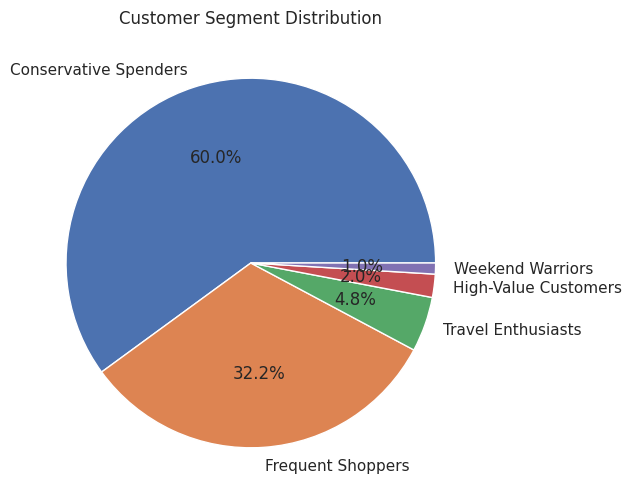

In [ ]:
# === CUSTOMER SEGMENTATION USING K-MEANS ===

print("=== CUSTOMER SEGMENTATION ANALYSIS ===")

# Select features for clustering
clustering_features = [
    'avg_transaction_amount', 'transaction_consistency',
    'transaction_frequency', 'weekend_preference',
    'travel_tendency', 'spending_hour_consistency'
]

# Handle missing values
cluster_data = customer_profiles[clustering_features].fillna(customer_profiles[clustering_features].median())

# Standardize features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Perform K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
customer_profiles['cluster'] = kmeans.fit_predict(scaled_data)

# Add meaningful cluster names
cluster_names = {
    0: 'Conservative Spenders',
    1: 'High-Value Customers',
    2: 'Frequent Shoppers',
    3: 'Weekend Warriors',
    4: 'Travel Enthusiasts'
}
customer_profiles['cluster_name'] = customer_profiles['cluster'].map(cluster_names)

# Display cluster summary
print("=== CLUSTER SUMMARY ===")
cluster_summary = customer_profiles.groupby('cluster_name').agg({
    'avg_transaction_amount': 'mean',
    'transaction_frequency': 'mean',
    'weekend_preference': 'mean',
    'travel_tendency': 'mean'
}).round(2)

print(cluster_summary)

# Visualize clusters
plt.figure(figsize=(10, 6))
cluster_counts = customer_profiles['cluster_name'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.title('Customer Segment Distribution')
plt.show()

**12.Spending Pattern Analysis**

In [ ]:
# === SPENDING PATTERN ANALYSIS ===

print("=== COMPREHENSIVE SPENDING PATTERN ANALYSIS ===\n")

# 1. Category Analysis
print("1. SPENDING BY CATEGORY:")
category_stats = df_cleaned.groupby('category').agg({
    'amt': ['mean', 'sum', 'count'],
    'cc_num': 'nunique'
}).round(2)
category_stats.columns = ['Avg_Amount', 'Total_Amount', 'Transaction_Count', 'Unique_Customers']
category_stats_sorted = category_stats.sort_values('Total_Amount', ascending=False)
print(category_stats_sorted)

# 2. Time-based Analysis
print("\n2. SPENDING BY TIME PERIOD:")
time_stats = df_cleaned.groupby('time_period')['amt'].agg(['mean', 'sum', 'count']).round(2)
print(time_stats)

# 3. Gender Analysis
print("\n3. SPENDING BY GENDER:")
gender_stats = df_cleaned.groupby('gender').agg({
    'amt': ['mean', 'sum'],
    'category': lambda x: x.mode().iloc[0]
}).round(2)
gender_stats.columns = ['Avg_Amount', 'Total_Amount', 'Preferred_Category']
print(gender_stats)

# 4. Weekend vs Weekday Analysis
print("\n4. WEEKEND vs WEEKDAY SPENDING:")
weekend_stats = df_cleaned.groupby('is_weekend')['amt'].agg(['mean', 'sum', 'count']).round(2)
weekend_stats.index = ['Weekday', 'Weekend']
print(weekend_stats)

# 5. Hourly Pattern Analysis
print("\n5. PEAK ACTIVITY INSIGHTS:")
hourly_activity = df_cleaned.groupby('hour')['amt'].agg(['count', 'sum']).round(2)
peak_hour = hourly_activity['count'].idxmax()
peak_spending_hour = hourly_activity['sum'].idxmax()
print(f"Peak transaction hour: {peak_hour}:00")
print(f"Peak spending hour: {peak_spending_hour}:00")

=== COMPREHENSIVE SPENDING PATTERN ANALYSIS ===

1. SPENDING BY CATEGORY:
                Avg_Amount  Total_Amount  Transaction_Count  Unique_Customers
category                                                                     
grocery_pos         117.34    4370530.52              37247               935
shopping_pos         78.94    2767547.14              35061               927
shopping_net         90.18    2635229.28              29222               933
gas_transport        63.49    2506072.70              39469               932
home                 58.33    2147337.73              36814               909
kids_pets            57.45    1938011.63              33731               911
entertainment        64.22    1801354.26              28051               909
misc_net             81.96    1549371.98              18904               931
misc_pos             61.68    1457303.51              23626               912
travel              116.75    1414979.47              12120         

**13.Behavioral Anomaly Detection**

=== BEHAVIORAL ANOMALY DETECTION ===
Found 94 customers with unusual behavior patterns
Anomaly rate: 10.0%

=== TOP 5 MOST UNUSUAL CUSTOMERS ===
                     avg_transaction_amount  transaction_frequency  \
cc_num                                                               
4669558618943766                     732.36                     10   
4734310647841293                     356.32                      7   
3545578418030657                     513.61                      7   
38817501916673                       377.92                      8   
4714017207228610634                  700.09                      7   

                     travel_tendency  weekend_preference  anomaly_score  
cc_num                                                                   
4669558618943766               75.26                 1.0      -0.772957  
4734310647841293               62.87                 0.0      -0.766928  
3545578418030657               66.32                 0.0      -0.757

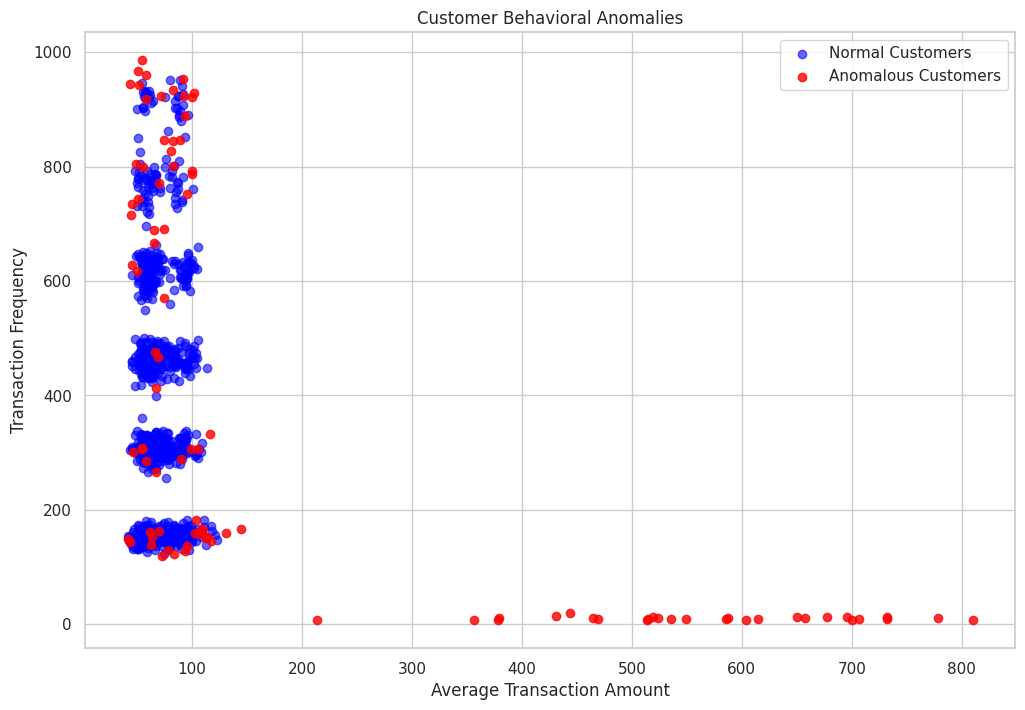

In [ ]:
# === BEHAVIORAL ANOMALY DETECTION ===

print("=== BEHAVIORAL ANOMALY DETECTION ===")

# Features for anomaly detection
anomaly_features = [
    'avg_transaction_amount', 'transaction_frequency',
    'travel_tendency', 'weekend_preference'
]

# Prepare data for anomaly detection
anomaly_data = customer_profiles[anomaly_features].fillna(customer_profiles[anomaly_features].median())

# Standardize data
scaler_anomaly = StandardScaler()
scaled_anomaly_data = scaler_anomaly.fit_transform(anomaly_data)

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
customer_profiles['is_anomaly'] = iso_forest.fit_predict(scaled_anomaly_data)
customer_profiles['anomaly_score'] = iso_forest.score_samples(scaled_anomaly_data)

# Identify anomalous customers
anomalies = customer_profiles[customer_profiles['is_anomaly'] == -1].sort_values('anomaly_score')

print(f"Found {len(anomalies)} customers with unusual behavior patterns")
print(f"Anomaly rate: {len(anomalies)/len(customer_profiles)*100:.1f}%")

print("\n=== TOP 5 MOST UNUSUAL CUSTOMERS ===")
anomaly_display = anomalies[['avg_transaction_amount', 'transaction_frequency',
                           'travel_tendency', 'weekend_preference', 'anomaly_score']].head()
print(anomaly_display)

# Visualize anomalies
plt.figure(figsize=(12, 8))
normal_customers = customer_profiles[customer_profiles['is_anomaly'] == 1]
anomalous_customers = customer_profiles[customer_profiles['is_anomaly'] == -1]

plt.scatter(normal_customers['avg_transaction_amount'], normal_customers['transaction_frequency'],
           c='blue', alpha=0.6, label='Normal Customers')
plt.scatter(anomalous_customers['avg_transaction_amount'], anomalous_customers['transaction_frequency'],
           c='red', alpha=0.8, label='Anomalous Customers')
plt.xlabel('Average Transaction Amount')
plt.ylabel('Transaction Frequency')
plt.title('Customer Behavioral Anomalies')
plt.legend()
plt.show()

**14.Business Insights Generation**

In [ ]:
# === ACTIONABLE BUSINESS INSIGHTS ===

print("=== ACTIONABLE BUSINESS INSIGHTS ===\n")

# 1. Customer Segment Insights
print("1. CUSTOMER SEGMENT CHARACTERISTICS:")
for cluster_name in cluster_summary.index:
    cluster_data = cluster_summary.loc[cluster_name]
    cluster_size = len(customer_profiles[customer_profiles['cluster_name'] == cluster_name])
    print(f"\n{cluster_name} ({cluster_size} customers):")
    print(f"  • Average Transaction: ${cluster_data['avg_transaction_amount']:.2f}")
    print(f"  • Transaction Frequency: {cluster_data['transaction_frequency']:.1f} transactions")
    print(f"  • Weekend Preference: {cluster_data['weekend_preference']:.2%}")
    print(f"  • Travel Tendency: {cluster_data['travel_tendency']:.2f} km average distance")

# 2. Demographic Preferences
print("\n2. DEMOGRAPHIC PREFERENCES:")
gender_category = df_cleaned.groupby(['gender', 'category']).size().unstack(fill_value=0)
for gender in ['M', 'F']:
    if gender in gender_category.index:
        top_category = gender_category.loc[gender].idxmax()
        percentage = gender_category.loc[gender].max() / gender_category.loc[gender].sum() * 100
        print(f"  • {gender}: Most popular category is {top_category} ({percentage:.1f}%)")

# 3. Geographic Insights
print("\n3. GEOGRAPHIC INSIGHTS:")
if 'city_pop' in df_cleaned.columns:
    city_spending = df_cleaned.groupby(pd.cut(df_cleaned['city_pop'],
                                             bins=[0, 5000, 50000, np.inf],
                                             labels=['Rural', 'Small City', 'Large City']))['amt'].mean()
    for area_type, avg_spending in city_spending.items():
        print(f"  • {area_type}: ${avg_spending:.2f} average transaction")

# 4. Temporal Insights
print("\n4. TEMPORAL PATTERNS:")
weekend_vs_weekday = df_cleaned.groupby('is_weekend')['amt'].mean()
weekend_lift = (weekend_vs_weekday[1] - weekend_vs_weekday[0]) / weekend_vs_weekday[0] * 100
print(f"  • Weekend spending is {weekend_lift:.1f}% {'higher' if weekend_lift > 0 else 'lower'} than weekdays")

top_spending_categories = df_cleaned.groupby('category')['amt'].sum().nlargest(3)
print(f"  • Top 3 spending categories: {', '.join(top_spending_categories.index)}")

=== ACTIONABLE BUSINESS INSIGHTS ===

1. CUSTOMER SEGMENT CHARACTERISTICS:

Conservative Spenders (562 customers):
  • Average Transaction: $71.36
  • Transaction Frequency: 288.5 transactions
  • Weekend Preference: 34.00%
  • Travel Tendency: 85.07 km average distance

Frequent Shoppers (301 customers):
  • Average Transaction: $68.24
  • Transaction Frequency: 673.4 transactions
  • Weekend Preference: 34.00%
  • Travel Tendency: 84.99 km average distance

High-Value Customers (19 customers):
  • Average Transaction: $532.42
  • Transaction Frequency: 10.3 transactions
  • Weekend Preference: 0.00%
  • Travel Tendency: 84.44 km average distance

Travel Enthusiasts (45 customers):
  • Average Transaction: $80.02
  • Transaction Frequency: 517.1 transactions
  • Weekend Preference: 36.00%
  • Travel Tendency: 85.31 km average distance

Weekend Warriors (9 customers):
  • Average Transaction: $634.55
  • Transaction Frequency: 10.4 transactions
  • Weekend Preference: 66.00%
  • Travel

**15.Comprehensive Visualization Dashboard**

=== CREATING VISUALIZATION DASHBOARD ===


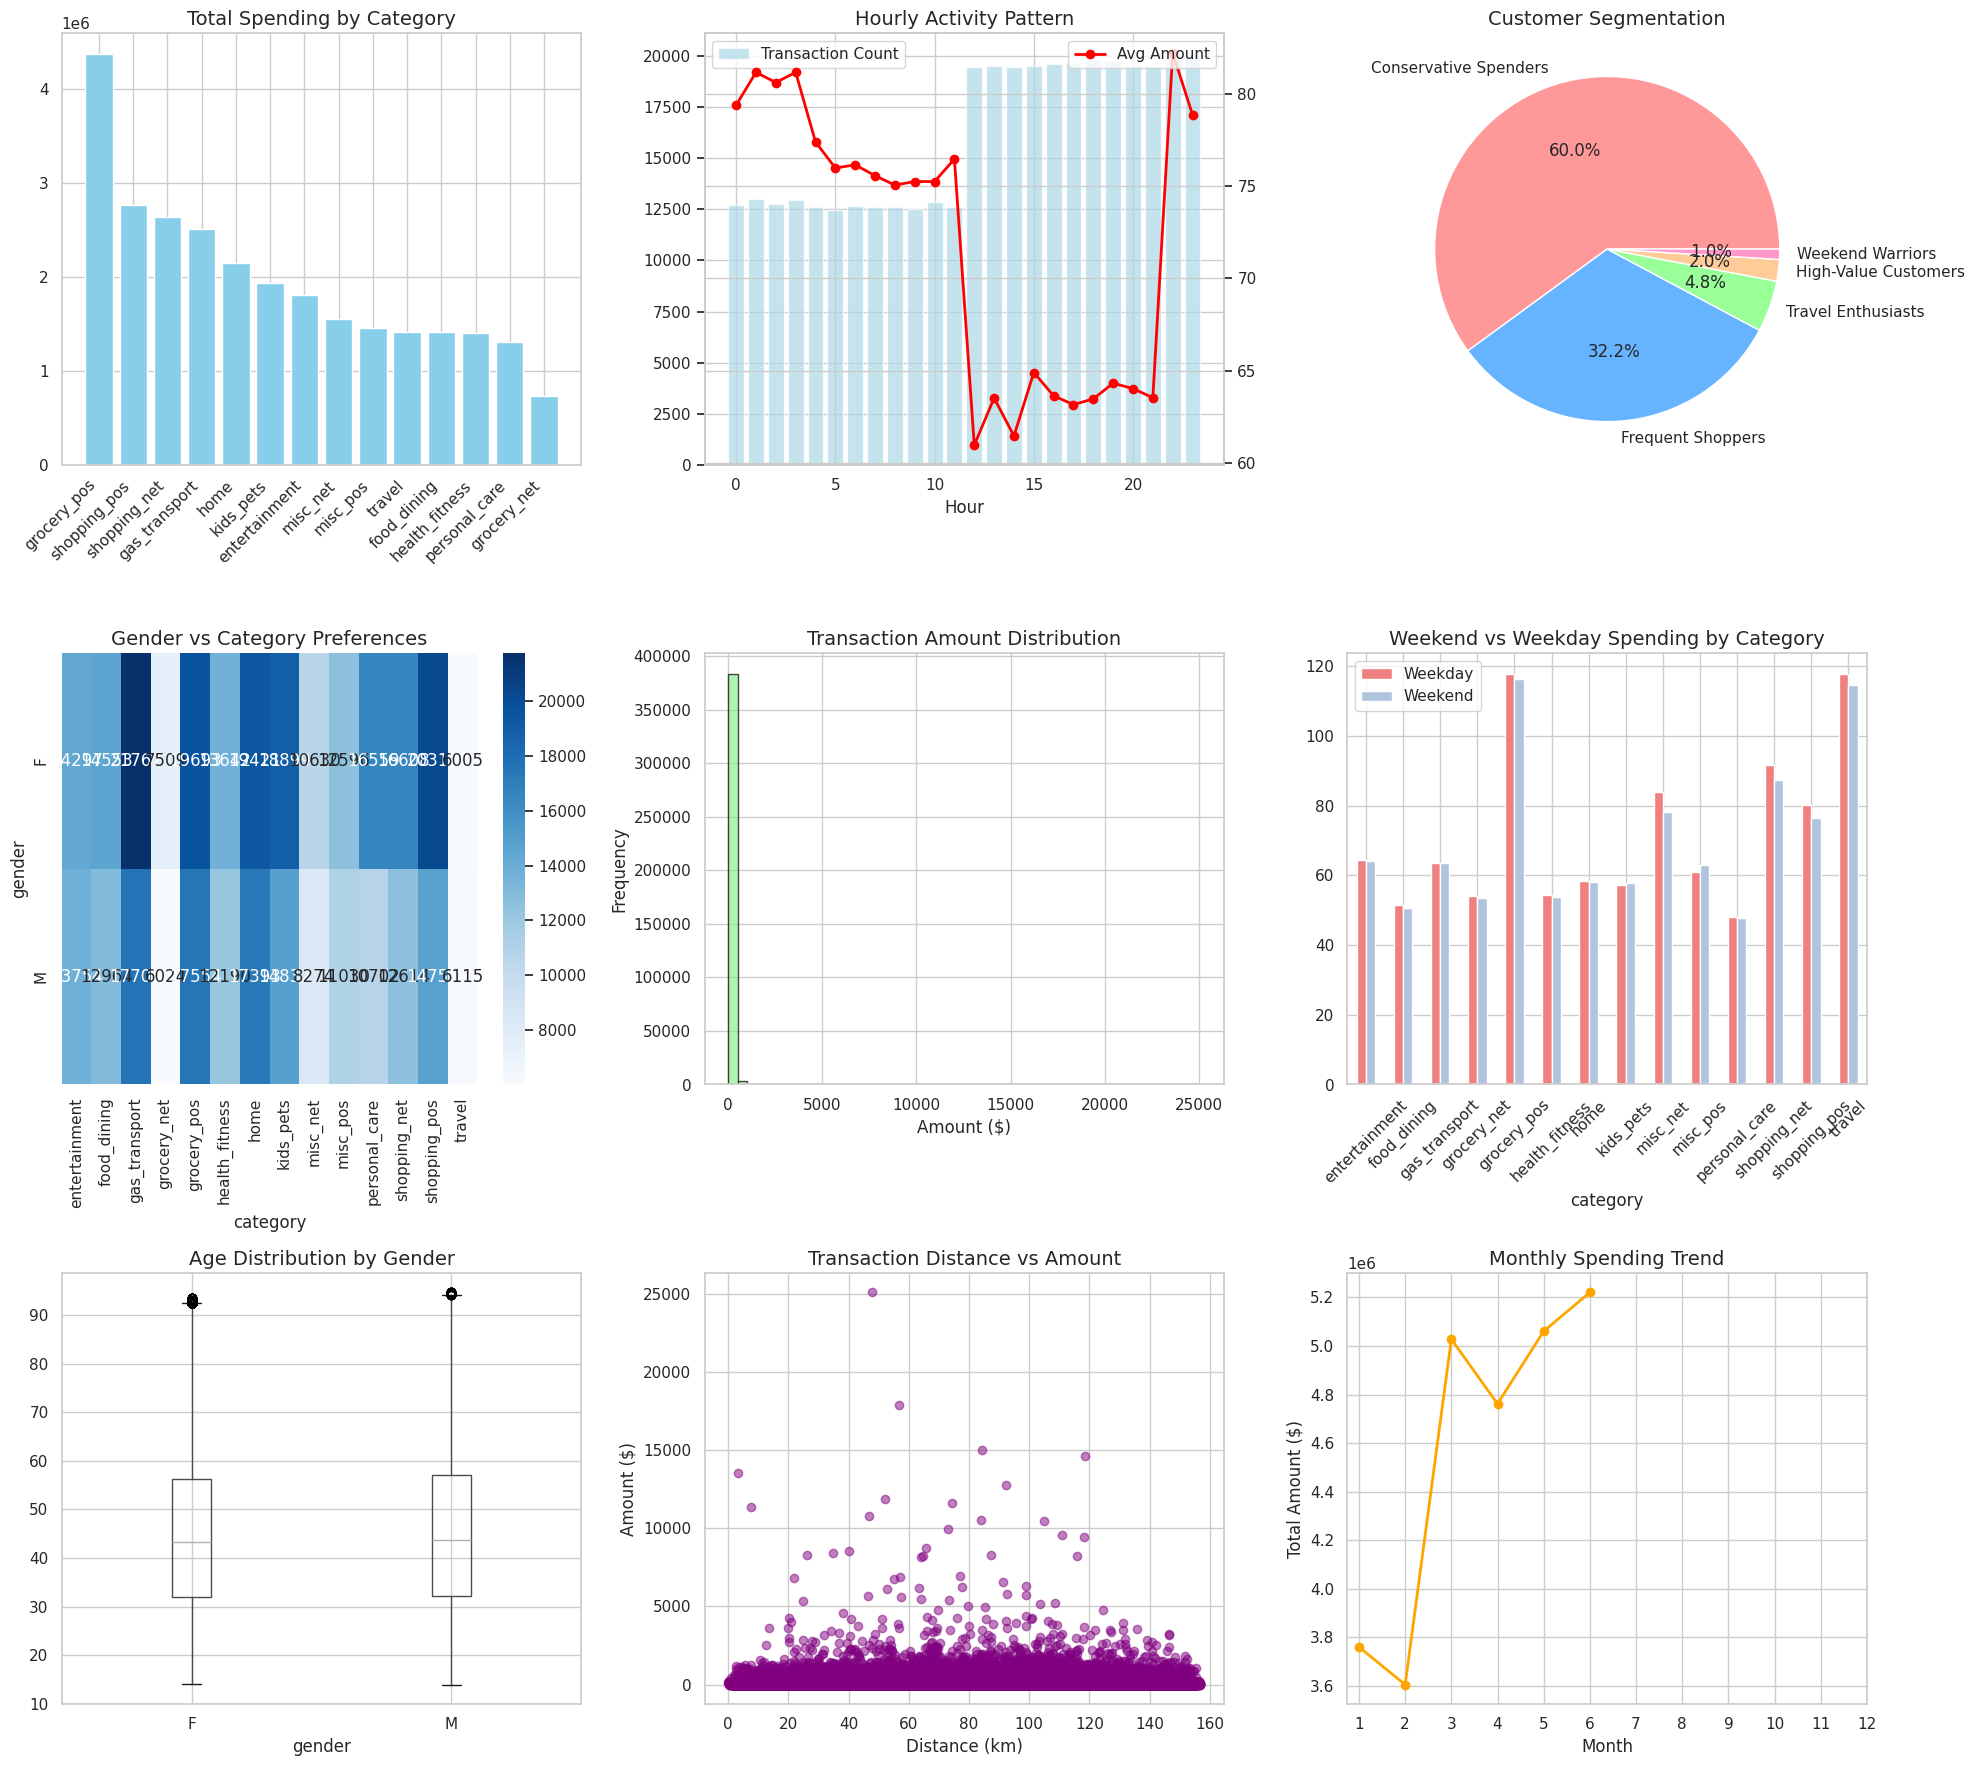

✅ Dashboard created successfully!


In [ ]:
# === COMPREHENSIVE VISUALIZATION DASHBOARD ===

print("=== CREATING VISUALIZATION DASHBOARD ===")

# Create comprehensive dashboard
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Credit Card Behavioral Analysis Dashboard', fontsize=20, y=0.98)

# 1. Spending by Category
category_totals = df_cleaned.groupby('category')['amt'].sum().sort_values(ascending=False)
axes[0,0].bar(range(len(category_totals)), category_totals.values, color='skyblue')
axes[0,0].set_title('Total Spending by Category', fontsize=14)
axes[0,0].set_xticks(range(len(category_totals)))
axes[0,0].set_xticklabels(category_totals.index, rotation=45, ha='right')

# 2. Hourly Activity Pattern
hourly_pattern = df_cleaned.groupby('hour')['amt'].agg(['count', 'mean'])
ax1 = axes[0,1]
ax2 = ax1.twinx()
bars = ax1.bar(hourly_pattern.index, hourly_pattern['count'], alpha=0.7, color='lightblue', label='Transaction Count')
line = ax2.plot(hourly_pattern.index, hourly_pattern['mean'], color='red', marker='o', linewidth=2, label='Avg Amount')
ax1.set_title('Hourly Activity Pattern', fontsize=14)
ax1.set_xlabel('Hour')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 3. Customer Clusters
cluster_counts = customer_profiles['cluster_name'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
axes[0,2].pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%', colors=colors)
axes[0,2].set_title('Customer Segmentation', fontsize=14)

# 4. Gender vs Category Heatmap
gender_category = df_cleaned.groupby(['gender', 'category']).size().unstack(fill_value=0)
sns.heatmap(gender_category, annot=True, cmap='Blues', ax=axes[1,0], fmt='d')
axes[1,0].set_title('Gender vs Category Preferences', fontsize=14)

# 5. Transaction Amount Distribution
axes[1,1].hist(df_cleaned['amt'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,1].set_title('Transaction Amount Distribution', fontsize=14)
axes[1,1].set_xlabel('Amount ($)')
axes[1,1].set_ylabel('Frequency')

# 6. Weekend vs Weekday by Category
weekend_comparison = df_cleaned.groupby(['category', 'is_weekend'])['amt'].mean().unstack()
weekend_comparison.plot(kind='bar', ax=axes[1,2], color=['lightcoral', 'lightsteelblue'])
axes[1,2].set_title('Weekend vs Weekday Spending by Category', fontsize=14)
axes[1,2].legend(['Weekday', 'Weekend'])
axes[1,2].tick_params(axis='x', rotation=45)

# 7. Age Distribution by Gender
df_cleaned.boxplot(column='age', by='gender', ax=axes[2,0])
axes[2,0].set_title('Age Distribution by Gender', fontsize=14)
plt.suptitle('')  # ✅ Remove the automatic pandas boxplot super-title


# 8. Distance vs Amount Scatter
scatter = axes[2,1].scatter(df_cleaned['distance'], df_cleaned['amt'], alpha=0.5, c='purple')
axes[2,1].set_title('Transaction Distance vs Amount', fontsize=14)
axes[2,1].set_xlabel('Distance (km)')
axes[2,1].set_ylabel('Amount ($)')

# 9. Monthly Spending Trend
monthly_spending = df_cleaned.groupby('month')['amt'].agg(['sum', 'mean'])
axes[2,2].plot(monthly_spending.index, monthly_spending['sum'], marker='o', linewidth=2, color='orange')
axes[2,2].set_title('Monthly Spending Trend', fontsize=14)
axes[2,2].set_xlabel('Month')
axes[2,2].set_ylabel('Total Amount ($)')
axes[2,2].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

print("✅ Dashboard created successfully!")

**16.Final Summary and Export Results**

In [ ]:
# === FINAL SUMMARY AND RESULTS EXPORT ===

print("=== CREDIT CARD BEHAVIORAL ANALYSIS COMPLETE ===\n")

# Summary Statistics
print("📊 ANALYSIS SUMMARY:")
print(f"• Total Transactions Analyzed: {len(df_cleaned):,}")
print(f"• Unique Customers: {df_cleaned['cc_num'].nunique():,}")
print(f"• Total Transaction Volume: ${df_cleaned['amt'].sum():,.2f}")
print(f"• Average Transaction Amount: ${df_cleaned['amt'].mean():.2f}")
print(f"• Customer Segments Identified: {n_clusters}")
print(f"• Behavioral Anomalies Detected: {len(anomalies)}")

# Key Insights
print(f"\n🎯 KEY INSIGHTS:")
print(f"• Highest spending category: {category_totals.index[0]} (${category_totals.iloc[0]:,.2f})")
print(f"• Peak transaction hour: {peak_hour}:00")
print(f"• Weekend vs Weekday difference: {weekend_lift:.1f}%")
print(f"• Largest customer segment: {cluster_counts.index[0]} ({cluster_counts.iloc[0]} customers)")

# Export results
try:
    # Export customer profiles
    customer_profiles.to_csv('/content/customer_behavioral_profiles.csv')

    # Export anomalies
    anomalies.to_csv('/content/behavioral_anomalies.csv')

    # Export spending patterns
    category_stats_sorted.to_csv('/content/spending_patterns_by_category.csv')

    print(f"\n💾 RESULTS EXPORTED:")
    print("• customer_behavioral_profiles.csv")
    print("• behavioral_anomalies.csv")
    print("• spending_patterns_by_category.csv")
    print("• credit_card_transactions_cleaned.csv")

except Exception as e:
    print(f"Export error: {e}")

print(f"\n✅ Analysis Complete! All data processed and insights generated.")
print("\n📋 USAGE SUMMARY:")
print("This analysis provides:")
print("1. Customer behavioral segmentation (5 distinct groups)")
print("2. Spending pattern analysis across multiple dimensions")
print("3. Anomaly detection for unusual customer behaviors")
print("4. Actionable business insights for decision making")
print("5. Comprehensive visualizations for presentation")

=== CREDIT CARD BEHAVIORAL ANALYSIS COMPLETE ===

📊 ANALYSIS SUMMARY:
• Total Transactions Analyzed: 388,388
• Unique Customers: 936
• Total Transaction Volume: $27,435,285.29
• Average Transaction Amount: $70.64
• Customer Segments Identified: 5
• Behavioral Anomalies Detected: 94

🎯 KEY INSIGHTS:
• Highest spending category: grocery_pos ($4,370,530.52)
• Peak transaction hour: 22:00
• Weekend vs Weekday difference: -1.9%
• Largest customer segment: Conservative Spenders (562 customers)

💾 RESULTS EXPORTED:
• customer_behavioral_profiles.csv
• behavioral_anomalies.csv
• spending_patterns_by_category.csv
• credit_card_transactions_cleaned.csv

✅ Analysis Complete! All data processed and insights generated.

📋 USAGE SUMMARY:
This analysis provides:
1. Customer behavioral segmentation (5 distinct groups)
2. Spending pattern analysis across multiple dimensions
3. Anomaly detection for unusual customer behaviors
4. Actionable business insights for decision making
5. Comprehensive visualiza